In [26]:
import librosa
import glob
import os
import dtw
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style='dark')
%matplotlib inline

import msaf # develop branch
from msaf import jams2
import numpy as np
import scipy
import mir_eval
import scipy.spatial.distance
from joblib import Parallel, delayed
import cPickle

In [10]:
ds_path = "/Users/uri/datasets/Segments/"
ds_path = "/home/uri/datasets/Segments/"

In [11]:
%run 'Cross-repetition DTW.ipynb'

IndexError: list index out of range

In [19]:
files = msaf.io.get_dataset_files(ds_path, ds_name="SALAMI")
print len(files)
ref_inter, ref_labels = jams2.converters.load_jams_range(
    files[0].ref_file, "sections", annotator=0, context="small_scale")
print files[0].ref_file
print ref_inter, ref_labels
D, labels = make_cost_matrix(files[0].audio_file, ref_inter, ref_labels, dist=scipy.spatial.distance.correlation)

769
/home/uri/datasets/Segments/references/SALAMI_396.jams
[[   0.       0.196]
 [   0.196    7.663]
 [   7.663   15.232]
 [  15.232   22.686]
 [  22.686   29.93 ]
 [  29.93    37.314]
 [  37.314   44.606]
 [  44.606   51.897]
 [  51.897   59.211]
 [  59.211   66.641]
 [  66.641   74.025]
 [  74.025   81.316]
 [  81.316   88.677]
 [  88.677   96.038]
 [  96.038  103.375]
 [ 103.375  110.713]
 [ 110.713  118.027]
 [ 118.027  125.388]
 [ 125.388  132.679]
 [ 132.679  140.063]
 [ 140.063  147.493]
 [ 147.493  154.854]
 [ 154.854  162.261]
 [ 162.261  169.742]
 [ 169.742  176.662]
 [ 176.662  179.67 ]] [u'z', u'b', u'b', u'c', u'd', u'e', u'e', u'e', u'e', u'f', u'f', u'f', u'f', u'g', u'g', u'g', u'g', u'h', u'h', u'h', u'h', u'i', u'i', u'j', u'k', u"z'"]


In [24]:
dist_dict = {
    "L1": lambda x, y: norm(x - y, ord=1),
    "L2": scipy.spatial.distance.euclidean,
    "correlation": scipy.spatial.distance.correlation
}

In [21]:
from IPython.html.widgets import interact

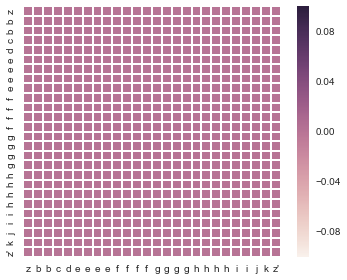

In [22]:
@interact(threshold=(0, D.max(), D.max()//50))
def _plot(threshold=0):
    plt.figure(figsize=(5,4))
    seaborn.heatmap((D<threshold), xticklabels=labels, yticklabels=labels)
    plt.tight_layout()

In [37]:
def compute_score(file_struct, level, dist_key):
    try:
        ref_inter, ref_labels = jams2.converters.load_jams_range(
            file_struct.ref_file, "sections", annotator=0, context=level)
        D, labels = make_cost_matrix(file_struct.audio_file, ref_inter, ref_labels, dist=dist_dict[dist_key])
    except:
        print "warning: no annotations for file", file_struct.audio_file
        return {
            "intervals": None,
            "labels": None,
            "scores": None,
            "file": os.path.basename(file_struct.audio_file)
        }
    ret = {
        "intervals": ref_inter,
        "labels": ref_labels,
        "scores": D,
        "file": os.path.basename(file_struct.audio_file)
    }
    return ret

In [ ]:
levels = ["large_scale", "small_scale"]
datasets = ["SALAMI", "Isophonics"]
n_jobs = 8

for dataset in datasets:
    for level in levels:
        for dist_key in dist_dict.keys():
            print "Computing: ", dataset, level, dist_key
            scores = Parallel(n_jobs=n_jobs)(delayed(compute_score)(
                file_struct, level, dist_key)
                for file_struct in files[:])
            result = {
                "level": level,
                "dist": dist_key,
                "file_scores": scores
            }
            out_file = "scores_datasetE%s_levelE%s_distE%s.pk" % (dataset, level, dist_key)
            with open(out_file, "w") as f:
                cPickle.dump(result, f)

Computing:  SALAMI large_scale correlation
